<a href="https://colab.research.google.com/github/mrinmoysarkar/ArtificialNeuralNetwork/blob/master/Copy_of_Copy_of_Meta_DRN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align="center">

## Meta-DRN: Meta-Learning for 1-Shot Image Segmentation

</div>

---

### Introduction
In this notebook we provide a PyTorch implementation of the paper [_Meta-DRN: Meta-Learning for 1-Shot Image Segmentation_](https://arxiv.org/pdf/2008.00247.pdf). The dataset used for training and testing the model is the [FSS-1000](https://github.com/HKUSTCV/FSS-1000) dataset which can be downloaded from this [link](https://drive.google.com/open?id=16TgqOeI_0P41Eh3jWQlxlRXG9KIqtMgI).

### Data Preparation
The model expects the user to extract the downlaoded zip file into a `data` directory located in the root directory. The folder structure of the `data` directory should be as follows

`data -> fewshot_data -> 1000 folders each representing a class`



### Dependencies

The following packages are needed

- torch==1.7.0
- torchvision==0.8.1
- pytorch_lightning==1.0.4
- matplotlib==3.3.2
- seaborn==0.11.0
- higher==0.2.1

The requirements can be installed by running the command `pip install -r requirements.txt` from inside the root directory. 

### Visualization
The metrics and intermediate results during training can be visualized in tensorboard. This will create a directory called `lightning_logs` inside the root directory. During training, tensorboard events as well as model checkpoints will be stored in this directory.

First, we install any missing dependencies


In [ ]:
!pip3 install pytorch-lightning higher

     |████████████████████████████████| 675kB 10.0MB/s 
     |████████████████████████████████| 829kB 16.4MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 276kB 23.5MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=3ed0f2e23651a655906a0c10f7ad59e3e32bc4269168e89955593a496e987ad2
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=cfcc0c22f47b89ed21878f32c27e8ff63c74b312b286bc79ce51b0354fb9b4ad
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
Successfully built future PyYAML
  Found existing installation: future 0.16.0
    Uninstalling future-0.16.0:
      Successfully uninstalled future-0.16.0
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully u

## Import the general libraries used

In [ ]:
#@title
# generic
import functools
import os, gc
import time
import random
import shutil
import zipfile
from collections import Counter, OrderedDict
from PIL import Image
from tqdm import tqdm

# numeric computation and plotting
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# deep learning
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from torchvision.io import read_image
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.parameter import Parameter
from torch._C import ParameterDict
from pytorch_lightning.metrics.functional.classification import iou
from torch.utils.tensorboard import SummaryWriter
from torch.optim import Optimizer
from higher.optim import DifferentiableOptimizer
from higher import register_optim
from torch.optim import AdamW
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensor
from torch.utils.data import Dataset
from torch import Tensor
from torch.nn import Module
from torch.types import Device

import builtins
from typing import Any, Callable, Dict, Mapping, Optional, Tuple, Type, Union, List

from copy import deepcopy
from collections import OrderedDict

import higher
from higher.optim import _GroupedGradsType, _torch, _math, _add, _addcdiv, _maybe_mask, DifferentiableAdam



import requests
from requests.models import Response

# seeding for reprocibility
seed_everything(1971) # 1971 --> random seed

# environment setup
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Model, Data and training configurations

In [ ]:
#@title
"""Configs for global use"""
global_config = {'seed': 1971}

"""Configs for the dataset options"""
data_config = {
    'data_root': 'data',
    'dataset_name': 'FSS-1000',
    'gdrive_file_id': '16TgqOeI_0P41Eh3jWQlxlRXG9KIqtMgI',
    'dataset_dir': 'fewshot_data',
    'img_height': 224,
    'img_width': 224,
    'n_classes': 1000,
    'n_train_classes': 700,
    'n_val_classes': 60,
    'n_test_classes': 240,
    'shuffle': True,
    'num_workers': 1,
    'normalize_mean': [0.485, 0.456, 0.406],
    'normalize_std': [0.229, 0.224, 0.225],
    'batch_size': 1,
    'maml': {
        'test_shots': 1,
        'train_shots': 1,
        'n_ways': 5
    },
    'fomaml': {
        'test_shots': 1,
        'train_shots': 1,
        'n_ways': 5
    },
    'meta-sgd': {
        'test_shots': 1,
        'train_shots': 1,
        'n_ways': 5
    },
    'reptile': {
        'test_shots': 1,
        'train_shots': 1,
        'n_ways': 5
    }
}

"""Configs for the model hyperparameters"""
model_config = {
    'head': {
        'conv1': {
            'in_channels': 3,
            'out_channels': 16,
            'kernel_size': 3,
            'stride': 2,
            'padding': 1,
            'dilation': 1
        },
        'bn1': {
            'num_features': 16
        },
        'conv2': {
            'in_channels': 16,
            'out_channels': 64,
            'kernel_size': 3,
            'stride': 1,
            'padding': 1,
            'dilation': 1
        },
        'bn2': {
            'num_features': 64
        }
    },
    'resblocks': {
        'resblock1': {
            'conv1': {
                'in_channels': 64,
                'out_channels': 128,
                'kernel_size': 3,
                'stride': 2,
                'padding': 1,
                'dilation': 1
            },
            'conv2': {
                'in_channels': 128,
                'out_channels': 128,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'dilation': 1
            }
        },
        'resblock2': {
            'conv1': {
                'in_channels': 128,
                'out_channels': 256,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'dilation': 1
            },
            'conv2': {
                'in_channels': 256,
                'out_channels': 256,
                'kernel_size': 3,
                'stride': 1,
                'padding': 2,
                'dilation': 2
            }
        },
        'resblock3': {
            'conv1': {
                'in_channels': 256,
                'out_channels': 512,
                'kernel_size': 3,
                'stride': 1,
                'padding': 2,
                'dilation': 2
            },
            'conv2': {
                'in_channels': 512,
                'out_channels': 512,
                'kernel_size': 3,
                'stride': 1,
                'padding': 4,
                'dilation': 4
            }
        }
    },
    'reducer': {
        'resblock1': {
            'in_channels': 64,
            'out_channels': 128,
            'kernel_size': 1,
            'stride': 2,
            'padding': 0,
            'dilation': 1
        },
        'resblock2': {
            'in_channels': 128,
            'out_channels': 256,
            'kernel_size': 1,
            'stride': 1,
            'padding': 0,
            'dilation': 1
        },
        'resblock3': {
            'in_channels': 256,
            'out_channels': 512,
            'kernel_size': 1,
            'stride': 1,
            'padding': 0,
            'dilation': 1
        }
    },
    'degrid': {
        'conv1': {
            'in_channels': 512,
            'out_channels': 512,
            'kernel_size': 3,
            'stride': 1,
            'padding': 2,
            'dilation': 2
        },
        'conv2': {
            'in_channels': 512,
            'out_channels': 512,
            'kernel_size': 3,
            'stride': 1,
            'padding': 1,
            'dilation': 1
        }
    },
    'upsample': {
        'conv': {
            'in_channels': 512,
            'out_channels': 32,
            'kernel_size': 3,
            'stride': 1,
            'padding': 1,
            'dilation': 1
        },
        'pixel_shuffle': {
            'upscale_factor': 4
        }
    }
}

"""Configs for training"""
train_config = {
    'ngpus': 1,
    'metrics': ['iou', 'learner_loss', 'meta_loss'],
    'n_epochs': 200,
    'maml': {
        'learner_lr': 1e-3,
        'meta_lr': 1e-3,
        'train_steps': 1,
        'halve_lr_every': 8,
        'lr_reduction_factor': 0.5,
        'metric_to_watch': 'mIoU'
    },
    'fomaml': {
        'learner_lr': 1e-3,
        'meta_lr': 1e-3,
        'train_steps': 1,
        'halve_lr_every': 8,
        'lr_reduction_factor': 0.5,
        'metric_to_watch': 'mIoU'
    },
    'meta-sgd': {
        'learner_lr': 1e-3,
        'meta_lr': 1e-3,
        'train_steps': 1,
        'halve_lr_every': 8,
        'lr_reduction_factor': 0.5,
        'metric_to_watch': 'iou'
    },
    'reptile': {
        'learner_lr': 1e-3,
        'meta_lr': 3e-2,
        'train_steps': 5,
        'final_meta_lr': 3e-5,
        'metric_to_watch': 'mIoU'
    }
}

"""Configs for utlities and transformations"""
utils_config = {
    'transforms': [{
        'transform': 'Resize',
        'params': {
            'height': data_config['img_height'],
            'width': data_config['img_width']
        }
    }, {
        'transform': 'HorizontalFlip'
    }, {
        'transform': 'VerticalFlip'
    }, {
        'transform': 'ShiftScaleRotate',
        'params': {
            'shift_limit': 0,
            'rotate_limit': 0
        }
    }, {
        'transform': 'RandomBrightnessContrast'
    }, {
        'transform': 'Normalize',
        'params': {
            'mean': [0.485, 0.456, 0.406],
            'std': [0.229, 0.224, 0.225]
        }
    }]
}

"""Configs for visualization"""
vis_config = {
    'tensorboard': {
        'logdir': 'logs',
        'progress_bar': ['iou', 'learner_loss', 'meta_loss']
    }
}

## Typings to stay consistent with PEP 484

In [ ]:
#@title
"""A list of common types used in multiple places."""

_int = builtins.int
_float = builtins.float
_tensor = Tensor

_opt_int = Optional[_int]
_opt_float = Optional[_float]
_opt_tensor = Optional[Tensor]

_inttuple = Tuple[_int, _int]
_floattuple = Tuple[_float, _float]
_strtuple = Tuple[str, str]
_ttuple = Tuple[Tensor, Tensor]
_opt_ttuple = Optional[_ttuple]

_intstr = Union[_int, str]
_intfloat = Union[_int, _float]

## Utilities for downloading the dataset

In [ ]:
#@title
"""Implementation of the torch dataset"""



def download_file_from_google_drive(file_id: str, destination: str) -> None:
    print("Downloading ", destination.rpartition("/")[-1])
    url = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(url, params={"id": file_id}, stream=True)
    token = get_confirm_token(response)
    if token:
        params = {"id": file_id, "confirm": token}
        response = session.get(url, params=params, stream=True)
    save_response_content(response, destination)


def get_confirm_token(response: Response) -> Union[str, None]:
    for key, value in response.cookies.items():
        if key.startswith("download_warning"):
            return value
    return None


def save_response_content(response: Response, destination: str) -> None:
    chunk_size = 32768
    with open(destination, "wb") as f:
        pbar = tqdm(total=None)
        progress = 0
        for chunk in response.iter_content(chunk_size):
            if chunk:  # filter out keep-alive new chunks
                progress += len(chunk)
                pbar.update(progress - pbar.n)
                f.write(chunk)
        pbar.close()


def count_parameters(model: Module) -> _int:
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def get_transforms() -> A.Compose:
    transforms = utils_config["transforms"]
    ts = []
    for t in transforms:
        trans = t["transform"]
        params = t.get("params", {})
        if hasattr(A, trans):
            if params is not None:
                ts.append(getattr(A, trans)(**params))
            else:
                ts.append(getattr(A, trans)(**params))
    transform = A.Compose([*ts, ToTensor()])
    return transform


def timer(func: Callable[..., Any]) -> Callable[..., Any]:
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        t1 = time.perf_counter()
        retval = func(*args, **kwargs)
        t2 = time.perf_counter()
        wrapper.time_taken = t2 - t1
        print("Time taken to run %s: %.2fs" % (func.__name__, t2 - t1))
        return retval

    return wrapper


class FSSDataset(Dataset):
    """A subclass of torch.utils.data.Dataset that reads images
    from the  dataset folder into the appropriate support and query
    sets defined in data_config.
    """
    folder = data_config['dataset_dir']

    def __init__(self,
                 root: str,
                 ways: _int,
                 shots: _int,
                 test_shots: _int,
                 meta_split: Optional[str] = 'train',
                 transform: Optional[Any] = None,
                 download: Optional[bool] = True,
                 test_samples: Optional[list] = None,
                 ):
        super().__init__()
        assert meta_split in ['train', 'val',
                          'test'], "meta-split must be either 'train',\
                 'val' or 'test'"

        self.ways = ways
        self.shots = shots
        self.transform = transform
        self.test_shots = test_shots
        self.meta_split = meta_split
        self.test_samples = test_samples
        if transform is None:
            self.transform = A.Compose([
                                        A.Normalize(mean=data_config['normalize_mean'], std=data_config['normalize_std']),
                                        ToTensor()
                                        ])
        else:
            self.transform = transform
        if download:
            self.download(root)

        self.root = os.path.expanduser(os.path.join(root, self.folder))
        all_classes = os.listdir(self.root)

        if meta_split == 'train':
            self.classes = [all_classes[i] for i in range(data_config['n_train_classes'])]
        elif meta_split == 'val':
            self.classes = [
                            all_classes[i]
                            for i in range(data_config['n_train_classes'], data_config['n_train_classes'] +
                                           data_config['n_val_classes'])
                            ]
        else:
            self.classes = [
                            all_classes[i]
                            for i in range(data_config['n_train_classes'] +
                                           data_config['n_val_classes'], data_config['n_classes'])
                            ]

        self.num_classes = len(self.classes)

    def thresh_mask(self, mask, thresh=0.5):
        thresh = (mask.min() + mask.max()) * thresh
        mask = mask > thresh
        return mask.long()

    def make_batch(self, classes):
        shots = self.shots + self.test_shots
        batch = torch.zeros((shots, self.ways, 4, 224, 224))
        for i in range(shots):
            for j, cname in enumerate(classes):
                img_id = str(random.choice(list(range(1, 11))))
                img = Image.open(os.path.join(self.root, cname,
                                            img_id + '.jpg')).convert('RGB')
                mask = Image.open(os.path.join(self.root, cname,
                                            img_id + '.png')).convert('RGB')
                img, mask = np.array(img), np.array(mask)[:, :, 0]
                transformed = self.transform(image=img, mask=mask)
                batch[i, j, :3, :, :] = transformed['image']
                batch[i, j, 3:, :, :] = self.thresh_mask(transformed['mask'])
        return batch

    @staticmethod
    def break_batch(batch, shots, ways, shuffle=True):
        permute = torch.randperm(ways) if shuffle else torch.arange(ways)
        train_images, train_masks = batch[:, :shots, permute, :3, :, :],\
            batch[:, :shots, permute, 3:, :, :]

        test_images, test_masks = batch[:, shots:, :, :3, :, :],\
            batch[:, shots:, :, 3:, :, :]

        return (train_images, train_masks), (test_images, test_masks)

    def __getitem__(self, class_index):
        if self.test_samples is not None:
            classes = self.test_samples
        else:
            classes = [
                    self.classes[i] for i in range(class_index, (class_index + self.ways) %
                                                    (self.num_classes+1))
                    ]
        # print(len(classes), class_index)
        batch = self.make_batch(classes)
        return batch

    def __len__(self):
        return self.num_classes - self.ways + 1

    def download(self, root, remove_zip=True):
        filename = data_config['dataset_dir'] + '.zip'

        if os.path.exists(root):
            return

        file_id = data_config['gdrive_file_id']

        download_file_from_google_drive(file_id, filename)

        with zipfile.ZipFile(filename, 'r') as f:
            f.extractall()

        if remove_zip:
            os.remove(filename)

        shutil.move(data_config['dataset_dir'], root)


In [ ]:
#@title
"""Helper functions for retrieving dataloaders"""


def get_dataset(algo: str, meta_split='train', test_samples=None):
    """Retrieves dataset corresponding to parameters
        defined in config module for the meta learning algorithm used.

    Args:
      algo (str): Meta learning algorithm from [maml, fomaml,\
       meta-sgd, reptile]
      meta_split (str, optional): 'train' or 'test' split of the data.\
       Defaults to 'train'.

    Returns:
      Dataset: An instance of the Dataset class.
    """
    transform = get_transforms()
    data_root = data_config['data_root']
    n_ways = data_config[algo]['n_ways']
    train_shots = data_config[algo]['train_shots']
    test_shots = data_config[algo]['test_shots']

    dataset = FSSDataset(data_root, n_ways, train_shots, test_shots, meta_split,
                       transform, test_samples=test_samples)
    return dataset


def get_dataloader(algo: str, meta_split='train', test_samples=None):
    """Retrieves a PyTorch dataloader. Parameters for the dataloader can be
        found in the data_config module

    Args:
      algo (str): Meta learning algorithm from [maml, fomaml,
       meta-sgd, reptile]
      meta_split (str, optional): 'train' or 'test' split of the data.
       Defaults to 'train'.

    Returns:
      DataLoader: An instance of DataLoader class.
    """
    batch_size = data_config['batch_size']
    num_workers = data_config['num_workers']
    dataset = get_dataset(algo, meta_split, test_samples=test_samples)
    shuffle = meta_split == 'train'
    return DataLoader(dataset,
                    batch_size,
                    shuffle=shuffle,
                    num_workers=num_workers)


def split_batch(
    batch: Tensor,
    algo: str,
    meta_split: str) -> Tuple[Tuple[Tensor, Tensor], Tuple[Tensor, Tensor]]:
    """Splits a batch of data into image and mask pairs from the support
        set and the query set.

    Args:
      batch (Tensor): A torch.Tensor returned by the dataloader
      algo (str): Meta learning algorithm from [maml, fomaml,
       meta-sgd, reptile]

    Returns:
      [[Tensor, Tensor], [Tensor, Tensor]: Four Tensors paired into two tuples.
      (support_images, support_targets), (query_images, query_targets)
    """
    n_ways = data_config[algo]['n_ways']
    train_shots = data_config[algo]['train_shots']
    shuffle = meta_split == 'train'
    return FSSDataset.break_batch(batch, train_shots, n_ways, shuffle)


## Configuring the AdamW optimizer for the learner and the meta learner with the appropriate schedulers

In [ ]:
#@title

class DifferentiableAdamW(DifferentiableOptimizer):
    r"""A differentiable version of the Adam optimizer.

        This optimizer creates a gradient tape as it updates parameters."""

    def _update(self, grouped_grads: _GroupedGradsType, **kwargs) -> None:
    
        zipped = zip(self.param_groups, grouped_grads)
        for group_idx, (group, grads) in enumerate(zipped):
            amsgrad = group['amsgrad']
            beta1, beta2 = group['betas']
            weight_decay = group['weight_decay']

            for p_idx, (p, g) in enumerate(zip(group['params'], grads)):

                if g is None:
                    continue

                # Perform stepweight decay
                if group['lr']==1.0:
                    p = p * (1 - self.task_lr[p_idx] * weight_decay)
                else:
                    p = p * (1 - group['lr'] * weight_decay)

                if g.is_sparse:
                    raise RuntimeError('AdamW does not support sparse gradients')

                state = self.state[group_idx][p_idx]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = _torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = _torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. mov. avg. of sq. grad. vals
                        state['max_exp_avg_sq'] = _torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']

                state['step'] += 1
                bias_correction1 = 1 - beta1**state['step']
                bias_correction2 = 1 - beta2**state['step']

                # Decay the first and second moment running average coefficient
                state['exp_avg'] = exp_avg = (exp_avg * beta1) + (1 - beta1) * g
                state['exp_avg_sq'] = exp_avg_sq = ((exp_avg_sq * beta2) +
                                                    (1 - beta2) * g * g)

                # Deal with stability issues
                mask = exp_avg_sq == 0.
                _maybe_mask(exp_avg_sq, mask)

                if amsgrad:
                    # Maintains the max of all 2nd moment running avg. till now
                    state['max_exp_avg_sq'] = max_exp_avg_sq = _torch.max(
                        max_exp_avg_sq, exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = _add(max_exp_avg_sq.sqrt() / _math.sqrt(bias_correction2), group['eps'])
                else:
                    denom = _add(exp_avg_sq.sqrt() / _math.sqrt(bias_correction2), group['eps'])

                if group['lr']==1.0:
                    step_size = (self.task_lr[p_idx]  / bias_correction1)
                else:
                    step_size = (group['lr']  / bias_correction1)

                group['params'][p_idx] = _addcdiv(p, -step_size, exp_avg, denom)

    def store_task_lr(self,task_lr):
        self.task_lr = task_lr

        

register_optim(AdamW, DifferentiableAdamW)

"""Utility functions for retrieving optimizers"""



def get_optimizers(
    module: Module,
    algo: str) -> Any:
    meta_lr = train_config[algo]['meta_lr']
    learner_lr = train_config[algo]['learner_lr']
    n_epochs = train_config['n_epochs']
    if algo == 'meta-sgd':
        meta_optimizer = optim.AdamW(list(module.parameters())+list(module.task_lr.values()), 
                                     meta_lr)
        learner_optimizer = optim.AdamW(module.parameters(), 1.0)
    else:
        meta_optimizer = optim.AdamW(module.parameters(), meta_lr)
        learner_optimizer = optim.AdamW(module.parameters(), learner_lr)
    
    if algo in ['maml', 'fomaml', 'meta-sgd']:
        patience = train_config[algo]['halve_lr_every']
        lr_red = train_config[algo]['lr_reduction_factor']
        metric_to_watch = train_config[algo]['metric_to_watch']
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(meta_optimizer, 'max',
                                                        lr_red, patience)
        return {
            'meta_optimizer': meta_optimizer,
            'learner_optimizer': learner_optimizer,
            'scheduler': scheduler,
            'monitor': metric_to_watch
        }

    else:
        final_meta_lr = train_config[algo]['final_meta_lr']
        metric_to_watch = train_config[algo]['metric_to_watch']
        slope = (meta_lr - final_meta_lr) / n_epochs
        scheduler = optim.lr_scheduler.LambdaLR(meta_optimizer, lambda epoch:
                                                (epoch + 1) * slope)
        return {
            'meta_optimizer': meta_optimizer,
            'learner_optimizer': learner_optimizer,
            'scheduler': scheduler,
            'monitor': metric_to_watch
        }


## Defining the model architecture in PyTorch

In [ ]:
#@title
""" Residual components of the network"""


class Resblock(nn.Module):

    def __init__(self, block_id: int):
        super().__init__()
        self.block_id = 'resblock%d' % block_id

        self.add_module('conv1',
                        nn.Conv2d(**model_config['resblocks'][self.block_id]['conv1']))
        self.add_module('conv2',
                        nn.Conv2d(**(model_config['resblocks'][self.block_id]['conv2'])))
        self.add_module('reducer', nn.Conv2d(**model_config['reducer'][self.block_id]))

    def forward(self, x: Tensor):
        x_init = x

        for i, block in enumerate(self.children()):
            if i == 2:
                break
            x = block(x)

        return x + block(x_init)

"""Implements the model described in arxiv.2008.00247"""



"""MetaDRN architectured described in arxiv.2008.00247"""

class MetaDRN(nn.Module):
    def __init__(self, algo='maml', init_inner_learner_lr=1e-3):
        super().__init__()
        # Definet the network
        self.head = nn.Sequential()
        self.head.add_module("conv1", nn.Conv2d(**model_config["head"]["conv1"]))
        self.head.add_module("bn1", nn.BatchNorm2d(**model_config["head"]["bn1"]))
        self.head.add_module("lr1", nn.LeakyReLU())
        self.head.add_module("conv2", nn.Conv2d(**model_config["head"]["conv2"]))
        self.head.add_module("bn2", nn.BatchNorm2d(**model_config["head"]["bn2"]))
        self.head.add_module("lr2", nn.LeakyReLU())

        self.resblock1 = nn.Sequential()
        self.resblock1.add_module("resblock1", Resblock(1))
        
        self.resblock2 = nn.Sequential()
        self.resblock2.add_module("resblock2", Resblock(2))
        
        self.resblock3 = nn.Sequential()
        self.resblock3.add_module("resblock3", Resblock(3))

        self.degrid = nn.Sequential()
        self.degrid.add_module("conv1", nn.Conv2d(**model_config["degrid"]["conv1"]))
        self.degrid.add_module("conv2", nn.Conv2d(**model_config["degrid"]["conv2"]))

        self.upsample = nn.Sequential(
            OrderedDict([("conv1", nn.Conv2d(**model_config["upsample"]["conv"])),
                         ("pixel_shuffle",
                          nn.PixelShuffle(**model_config["upsample"]["pixel_shuffle"]))]))
        if algo == "meta-sgd":
            self.task_lr = OrderedDict()
            self.init_inner_learner_lr = init_inner_learner_lr

    def forward(self, x):
        return self.upsample(self.degrid(self.resblock3(self.resblock2(self.resblock1(self.head(x))))))

    def define_task_lr_params(self):
        for key, val in self.named_parameters():
            self.task_lr[key] = nn.Parameter(
                self.init_inner_learner_lr * torch.ones_like(val, requires_grad=True).cuda())



## Model output visualization helper functions

In [ ]:
#@title
# %matplotlib inline
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

unorm = UnNormalize(mean=data_config['normalize_mean'], std=data_config['normalize_std'])

activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def max_meanFeature(x):
    return x[torch.arange(x.size(0)),
             torch.argmax(torch.mean(x, dim=(2,3)), dim=1),
             :,
             :].view(-1,1,x.size(2),x.size(3))

def get_matplotFig(spt_x, spt_y, qry_x, qry_y):
    # plt.ioff()
    nrows = spt_x.shape[0]
    ncols = 2
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols,2*nrows), gridspec_kw = {'wspace':0, 'hspace':0})
    xlabels = ["Support","MAML"]
    for i in range(nrows):
        for j in range(ncols):
            if j==0:
                img = spt_x[i,:,:,:]
                musk = spt_y[i,:,:,:]
            else:
                img = qry_x[i,:,:,:]
                musk = qry_y[i,:,:,:]
            img = img.cpu()
            img = unorm(img)
            img = img.permute(1,2,0)
            musk = musk.cpu()
            musk = musk.permute(1,2,0)
            musk_with_alpha = np.zeros(shape=(musk.shape[0], musk.shape[1], 4),dtype=np.float)
            musk_with_alpha[:,:,1-j] = musk[:,:,0]
            musk_with_alpha[:,:,3] = musk[:,:,0]/2.5

            axs[i][j].imshow(img)
            axs[i][j].imshow(musk_with_alpha)
            # axs[i][j].set_axis_off()
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])
            if i == nrows-1:
                axs[i][j].set_xlabel(xlabels[j],size=16)
            
    return fig

def get_matplotFig_with_out_dict(spt_x, spt_y, out_dict):
    nrows = spt_x.shape[0]
    ncols = 1 + len(out_dict)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols,2*nrows), gridspec_kw = {'wspace':0, 'hspace':0})
    keys = list(out_dict.keys())
    xlabels = ["Support"] + keys
    for i in range(nrows):
        for j in range(ncols):
            if j==0:
                img = spt_x[i,:,:,:]
                musk = spt_y[i,:,:,:]
            else:
                img = out_dict[keys[j-1]][0][i,:,:,:]
                musk = out_dict[keys[j-1]][1][i,:,:,:]
            img = img.cpu()
            img = unorm(img)
            img = img.permute(1,2,0)
            musk = musk.cpu()
            musk = musk.permute(1,2,0)
            musk_with_alpha = np.zeros(shape=(musk.shape[0], musk.shape[1], 4),dtype=np.float)
            musk_with_alpha[:,:, 1 if j==0 else 0] = musk[:,:,0]
            musk_with_alpha[:,:,3] = musk[:,:,0]/2.5

            axs[i][j].imshow(img)
            axs[i][j].imshow(musk_with_alpha)
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])
            if i == nrows-1:
                axs[i][j].set_xlabel(xlabels[j],size=16)
            
    return fig

def get_activationFig(spt_x, spt_y, qry_x, out_y, activation):
    nrows = spt_x.size(0)
    ncols = 8
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(2*ncols,2*nrows), gridspec_kw = {'wspace':0, 'hspace':0})
    keys = list(activation.keys())
    activation = {key:max_meanFeature(activation[key]) for key in keys}
    xlabels = ["Support","Image","Head","ResBlock-1","ResBlock-2","ResBlock-3","Degrid","Final output"]
    for i in range(nrows):
        for j in range(ncols):
            if j==0:
                img = spt_x[i,:,:,:]
                musk = spt_y[i,:,:,:]
                img = unorm(img)
                musk = musk.cpu()
            elif j==1:
                img = qry_x[i,:,:,:]
                img = unorm(img)
            elif j==ncols-1:
                img = out_y[i,:,:,:]
            else:
                img = activation[keys[j-2]]
                img = img[i,:,:,:]
                img = (img - img.mean())/img.std()
            
            img = img.permute(1,2,0)
            img = img.cpu()
            if 0<=j<=1:
                axs[i][j].imshow(img)
            else:
                axs[i][j].imshow(img.squeeze(),cmap='gray')
            if j == 0:
                musk = musk.permute(1,2,0)
                musk_with_alpha = np.zeros(shape=(musk.shape[0], musk.shape[1], 4),dtype=np.float)
                musk_with_alpha[:,:,1-j] = musk[:,:,0]
                musk_with_alpha[:,:,3] = musk[:,:,0]/2.5
                axs[i][j].imshow(musk_with_alpha)
            # axs[i][j].set_axis_off()
            axs[i][j].set_xticks([])
            axs[i][j].set_yticks([])
            if i == nrows-1:
                axs[i][j].set_xlabel(xlabels[j],size=16)
            
    return fig
    
def add_hook_to_Model(net):
    net.head.register_forward_hook(get_activation('head'))
    net.resblock1.register_forward_hook(get_activation('resblock1'))
    net.resblock2.register_forward_hook(get_activation('resblock2'))
    net.resblock3.register_forward_hook(get_activation('resblock3'))
    net.degrid.register_forward_hook(get_activation('degrid'))


## Model training loop

In [ ]:
#@title
def train(net, loader, epoch=0, writer=None):
    net.train()
    qry_losses = []
    qry_ious = []
    pbar = tqdm(loader)
    
    for batch_idx, batch in enumerate(pbar):
        (spt_x, spt_y), (qry_x, qry_y ) = split_batch(batch, algo, 'train')
        
        spt_x, spt_y = spt_x.view(-1, *spt_x.shape[3:]).cuda(), spt_y.view(
           -1, *spt_y.shape[3:]).cuda()
        qry_x, qry_y = qry_x.view(-1, *qry_x.shape[3:]).cuda(), qry_y.view(
           -1, *qry_y.shape[3:]).cuda()

        
        if algo in ['maml', 'fomaml', 'meta-sgd']:
            meta_optim.zero_grad()
            with higher.innerloop_ctx(net, learner_optim, 
                                        copy_initial_weights=False, 
                                        track_higher_grads=(algo in ['maml','meta-sgd'])) as (fnet, diffoptim):
                for i in range(train_config[algo]['train_steps']):
                    pred = fnet(spt_x)
                    loss = F.cross_entropy(pred, spt_y.squeeze().long())
                    if i==0 and algo == 'meta-sgd':
                        diffoptim.store_task_lr(list(net.task_lr.values()))
                    diffoptim.step(loss)

                qry_logits = fnet(qry_x)
                qry_loss = F.cross_entropy(qry_logits, qry_y.squeeze().long())
                
                qry_losses.append(qry_loss.detach())
                with torch.no_grad():
                    qry_iou = iou(torch.argmax(qry_logits, dim=1), qry_y.squeeze().long())
                    qry_ious.append(qry_iou)
                qry_loss.backward()
            meta_optim.step()
            lr_scheduler.step(qry_losses[-1])
            pbar.set_description("Epoch: %d, training Loss: %.2f, mIoU: %.2f, time: %s" %
                                (epoch, qry_losses[-1], qry_ious[-1], time.strftime('%X')))
        elif algo == 'reptile':
            weights_before = deepcopy(net.state_dict())
            for _ in range(train_config[algo]['train_steps']):
                    pred = net(spt_x)
                    loss = F.cross_entropy(pred, spt_y.squeeze().long())
                    net.zero_grad()
                    loss.backward()
                    learner_optim.step()
            
            with torch.no_grad():
                qry_logits = net(qry_x)
                qry_loss = F.cross_entropy(qry_logits, qry_y.squeeze().long())
                qry_losses.append(qry_loss.detach())
                qry_iou = iou(torch.argmax(qry_logits, dim=1), qry_y.squeeze().long())
                qry_ious.append(qry_iou)
                pbar.set_description("Epoch: %d, training Loss: %.2f, mIoU: %.2f, time: %s" %
                                (epoch, qry_losses[-1], qry_iou, time.strftime('%X')))
            net.zero_grad()
            weights_after = deepcopy(net.state_dict())
            net.load_state_dict(weights_before)
            for name, param in net.named_parameters():
                param.grad.data = weights_before[name].data - weights_after[name].data
            meta_optim.step()

            
    if algo == 'reptile':
        lr_scheduler.step()
    

    qry_loss_epoch = sum(qry_losses) / len(qry_losses)
    qry_iou_epoch= sum(qry_ious) / len(qry_ious)
    print("loss: {} iou: {}".format(qry_loss_epoch, qry_iou_epoch))
    if writer is not None:
        writer.add_scalar('training loss', qry_loss_epoch, epoch)
        writer.add_scalar('training mIoU', qry_iou_epoch, epoch)



## Model testing loop

In [ ]:
#@title
def test(net, loader, epoch=0, writer=None):
    net.train()
    qry_losses = []
    qry_ious = []
    pbar = tqdm(loader)
    
    for batch_idx, batch in enumerate(pbar):
        (spt_x, spt_y), (qry_x, qry_y ) = split_batch(batch, algo, 'test')
       
        
        spt_x, spt_y = spt_x.view(-1, *spt_x.shape[3:]).cuda(), spt_y.view(
           -1, *spt_y.shape[3:]).cuda()
        qry_x, qry_y = qry_x.view(-1, *qry_x.shape[3:]).cuda(), qry_y.view(
           -1, *qry_y.shape[3:]).cuda()

        
        if algo in ['maml', 'fomaml', 'meta-sgd']:
            
            with higher.innerloop_ctx(net, learner_optim, 
                                        copy_initial_weights=True, 
                                        track_higher_grads=False) as (fnet, diffoptim):
                for i in range(train_config[algo]['train_steps']):
                    pred = fnet(spt_x)
                    loss = F.cross_entropy(pred, spt_y.squeeze().long())
                    if i==0 and algo == 'meta-sgd':
                        diffoptim.store_task_lr(list(net.task_lr.values()))
                    diffoptim.step(loss)
                with torch.no_grad():
                    add_hook_to_Model(fnet)
                    qry_logits = fnet(qry_x)
                    qry_loss = F.cross_entropy(qry_logits, qry_y.squeeze().long())
                    qry_losses.append(qry_loss.detach())
                    qry_iou = iou(torch.argmax(qry_logits, dim=1), qry_y.squeeze().long())
                    qry_ious.append(qry_iou)
                
                    pbar.set_description("Epoch: %d, testing Loss: %.2f, mIoU: %.2f, time: %s" %
                                (epoch, qry_losses[-1], qry_ious[-1], time.strftime('%X')))
                    out_y = torch.argmax(qry_logits, dim=1, keepdim=True)
                    act_fig = get_activationFig(spt_x.clone(), spt_y.clone(), qry_x.clone(), out_y.clone(), activation)
                    fig = get_matplotFig(spt_x.clone(), spt_y.clone(), qry_x.clone(), out_y.clone())
                    
                    if writer is not None:
                        writer.add_figure("testing_images", fig, batch_idx)
                        writer.add_figure("testing_activation_images", act_fig, batch_idx)
        elif algo == 'reptile':
            weights_before = deepcopy(net.state_dict())
            for _ in range(train_config[algo]['train_steps']):
                    pred = net(spt_x)
                    loss = F.cross_entropy(pred, spt_y.squeeze().long())
                    net.zero_grad()
                    loss.backward()
                    learner_optim.step()
            
            with torch.no_grad():
                add_hook_to_Model(net)
                qry_logits = net(qry_x)
                qry_loss = F.cross_entropy(qry_logits, qry_y.squeeze().long())
                qry_losses.append(qry_loss.detach())
                qry_iou = iou(torch.argmax(qry_logits, dim=1), qry_y.squeeze().long())
                qry_ious.append(qry_iou)
                pbar.set_description("Epoch: %d, testing Loss: %.2f, mIoU: %.2f, time: %s" %
                                (epoch, qry_losses[-1], qry_iou, time.strftime('%X')))
                out_y = torch.argmax(qry_logits, dim=1, keepdim=True)
                act_fig = get_activationFig(spt_x.clone(), spt_y.clone(), qry_x.clone(), out_y.clone(), activation)
                fig = get_matplotFig(spt_x.clone(), spt_y.clone(), qry_x.clone(), out_y.clone())
                
                if writer is not None:
                    writer.add_figure("testing_images", fig, batch_idx)
                    writer.add_figure("testing_activation_images", act_fig, batch_idx)

            net.load_state_dict(weights_before)

    qry_loss_epoch = sum(qry_losses) / len(qry_losses)
    qry_iou_epoch= sum(qry_ious) / len(qry_ious)
    print("loss: {} iou: {}".format(qry_loss_epoch, qry_iou_epoch))
    if writer is not None:
        writer.add_scalar('testing loss', qry_loss_epoch, epoch)
        writer.add_scalar('testing mIoU', qry_iou_epoch, epoch)
            



## Parameter Initialization

In [ ]:
#@title
# seeding
seed = 1971
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

# hyperparams
algo = 'meta-sgd'
n_epochs = train_config['n_epochs']
learner_lr = train_config[algo]['learner_lr']

# get dataloader
train_loader = get_dataloader(algo, 'train')
val_loader = get_dataloader(algo, 'val')
test_loader = get_dataloader(algo, 'test')
# get model
if True:
    net = MetaDRN(algo=algo)
    if algo == 'meta-sgd':
        net.define_task_lr_params()
else:
    net = torch.load("/content/drive/MyDrive/Colab Notebooks/models/meta_drn_maml_9.pt")
    net.eval()
net.cuda()
optimizers = get_optimizers(net, algo)
learner_optim = optimizers['learner_optimizer']
meta_optim = optimizers['meta_optimizer']
lr_scheduler = optimizers['scheduler']
metric_to_watch = optimizers['monitor']
# log data for tensorboard visualization
logs = vis_config['tensorboard']['logdir']+algo
writer = SummaryWriter(logs)

## Load Tensorboard for visualization

In [ ]:
%tensorboard --logdir "logsmaml"

## Start Training

In [ ]:
#@title
test_samples = ['pizza','eagle','ferrari911','american_alligator','bat']
new_dataloader = get_dataloader(algo,'test',test_samples=test_samples)
if __name__ == '__main__':
    for e in range(50):#n_epochs)
        train(net, new_dataloader, epoch=e, writer=writer)
        print("completed epoch {}".format(e))
        # if e%10==9:
        #     torch.save(net,"/content/drive/MyDrive/Colab Notebooks/models/meta_drn_"+algo+'_'+str(e)+'.pt')
       

Epoch: 0, training Loss: 395.40, mIoU: 0.42, time: 02:09:00: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 2640.80126953125 iou: 0.46646514534950256
completed epoch 0


Epoch: 1, training Loss: 427.43, mIoU: 0.52, time: 02:15:47: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 317.99395751953125 iou: 0.5238689184188843
completed epoch 1


Epoch: 2, training Loss: 457.63, mIoU: 0.48, time: 02:22:34: 100%|██████████| 236/236 [06:46<00:00,  1.72s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 315.6031188964844 iou: 0.5215963125228882
completed epoch 2


Epoch: 3, training Loss: 170.01, mIoU: 0.56, time: 02:29:22: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 306.13470458984375 iou: 0.5207889080047607
completed epoch 3


Epoch: 4, training Loss: 265.78, mIoU: 0.57, time: 02:36:09: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 294.0831604003906 iou: 0.5288760662078857
completed epoch 4


Epoch: 5, training Loss: 263.15, mIoU: 0.59, time: 02:42:57: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 285.6827087402344 iou: 0.5238978266716003
completed epoch 5


Epoch: 6, training Loss: 237.28, mIoU: 0.54, time: 02:49:44: 100%|██████████| 236/236 [06:47<00:00,  1.72s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 289.6773376464844 iou: 0.519018828868866
completed epoch 6


Epoch: 7, training Loss: 164.10, mIoU: 0.63, time: 02:56:32: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 279.3896789550781 iou: 0.5273248553276062
completed epoch 7


Epoch: 8, training Loss: 228.31, mIoU: 0.57, time: 03:03:19: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 277.72198486328125 iou: 0.524922788143158
completed epoch 8


Epoch: 9, training Loss: 175.17, mIoU: 0.57, time: 03:10:06: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 266.94091796875 iou: 0.5205633044242859
completed epoch 9


Epoch: 10, training Loss: 95.74, mIoU: 0.62, time: 03:16:54: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 251.35198974609375 iou: 0.5268479585647583
completed epoch 10


Epoch: 11, training Loss: 201.54, mIoU: 0.56, time: 03:23:42: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 253.8924102783203 iou: 0.521859884262085
completed epoch 11


Epoch: 12, training Loss: 161.17, mIoU: 0.56, time: 03:30:29: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 241.49203491210938 iou: 0.5282883048057556
completed epoch 12


Epoch: 13, training Loss: 241.35, mIoU: 0.52, time: 03:37:16: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 233.60043334960938 iou: 0.521378755569458
completed epoch 13


Epoch: 14, training Loss: 174.45, mIoU: 0.51, time: 03:44:04: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 222.92201232910156 iou: 0.5276917219161987
completed epoch 14


Epoch: 15, training Loss: 241.09, mIoU: 0.58, time: 03:50:52: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 222.476806640625 iou: 0.5219267010688782
completed epoch 15


Epoch: 16, training Loss: 238.97, mIoU: 0.57, time: 03:57:40: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 220.7146453857422 iou: 0.5229094624519348
completed epoch 16


Epoch: 17, training Loss: 160.14, mIoU: 0.54, time: 04:04:27: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 220.8262481689453 iou: 0.5204983353614807
completed epoch 17


Epoch: 18, training Loss: 285.04, mIoU: 0.52, time: 04:11:15: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 195.2852783203125 iou: 0.5289689898490906
completed epoch 18


Epoch: 19, training Loss: 184.05, mIoU: 0.54, time: 04:18:03: 100%|██████████| 236/236 [06:47<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 197.6778106689453 iou: 0.5238339900970459
completed epoch 19


Epoch: 20, training Loss: 286.69, mIoU: 0.42, time: 04:24:51: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 198.409423828125 iou: 0.519868016242981
completed epoch 20


Epoch: 21, training Loss: 126.86, mIoU: 0.57, time: 04:31:39: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 190.1998291015625 iou: 0.5201938152313232
completed epoch 21


Epoch: 22, training Loss: 167.48, mIoU: 0.55, time: 04:38:27: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 188.2562255859375 iou: 0.5153958797454834
completed epoch 22


Epoch: 23, training Loss: 246.93, mIoU: 0.44, time: 04:45:16: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 184.14564514160156 iou: 0.5201871395111084
completed epoch 23


Epoch: 24, training Loss: 208.41, mIoU: 0.56, time: 04:52:04: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 173.1836395263672 iou: 0.5246890187263489
completed epoch 24


Epoch: 25, training Loss: 169.88, mIoU: 0.50, time: 04:58:52: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 167.19403076171875 iou: 0.5250276923179626
completed epoch 25


Epoch: 26, training Loss: 154.85, mIoU: 0.44, time: 05:05:40: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 163.1778106689453 iou: 0.521533191204071
completed epoch 26


Epoch: 27, training Loss: 104.43, mIoU: 0.56, time: 05:12:28: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 158.0304718017578 iou: 0.5216836333274841
completed epoch 27


Epoch: 28, training Loss: 135.87, mIoU: 0.57, time: 05:19:17: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 156.75949096679688 iou: 0.5184754729270935
completed epoch 28


Epoch: 29, training Loss: 131.31, mIoU: 0.46, time: 05:26:05: 100%|██████████| 236/236 [06:48<00:00,  1.73s/it]
  0%|          | 0/236 [00:00<?, ?it/s]

loss: 146.33267211914062 iou: 0.5267399549484253
completed epoch 29


Epoch: 30, training Loss: 120.65, mIoU: 0.52, time: 05:28:05:  29%|██▉       | 68/236 [01:59<04:52,  1.74s/it]

## Validate the train Model

In [ ]:
#@title
test(net, val_loader, epoch=0, writer=None)#writer)

## Experiment with trained model

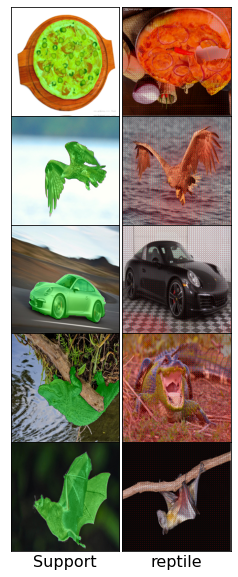

In [ ]:
#@title
test_samples = ['pizza','eagle','ferrari911','american_alligator','bat']
new_dataloader = get_dataloader(algo,'test',test_samples=test_samples)
for idx,batch in enumerate(new_dataloader):
    (spt_x, spt_y), (qry_x, qry_y ) = split_batch(batch, algo, 'test')
    spt_x, spt_y = spt_x.view(-1, *spt_x.shape[3:]).cuda(), spt_y.view(
        -1, *spt_y.shape[3:]).cuda()
    qry_x, qry_y = qry_x.view(-1, *qry_x.shape[3:]).cuda(), qry_y.view(
        -1, *qry_y.shape[3:]).cuda()
    
    if idx==0:
        break

out_dict = {}
algos = ['meta-sgd','maml','reptile','fomaml']
algos=['reptile']
for algo in algos:
    # # get model
    # if False:
    #     net = MetaDRN(algo=algo)
    #     if algo == 'meta-sgd':
    #         net.define_task_lr_params()
    # else:
    #     net = torch.load("/content/drive/MyDrive/Colab Notebooks/models/meta_drn_"+
    #                      algo+"_9.pt")
    # net.train()
    # net.cuda()
    optimizers = get_optimizers(net, algo)
    learner_optim = optimizers['learner_optimizer']
    meta_optim = optimizers['meta_optimizer']
    if algo in ['maml', 'fomaml', 'meta-sgd']:
        with higher.innerloop_ctx(net, learner_optim, 
                                    copy_initial_weights=True, 
                                    track_higher_grads=False) as (fnet, diffoptim):
            for i in range(train_config[algo]['train_steps']):
                pred = fnet(spt_x)
                loss = F.cross_entropy(pred, spt_y.squeeze().long())
                if i==0 and algo == 'meta-sgd':
                    diffoptim.store_task_lr(list(net.task_lr.values()))
                diffoptim.step(loss)
            with torch.no_grad():
                qry_logits = fnet(qry_x)
                out_y = torch.argmax(qry_logits, dim=1, keepdim=True)
                out_dict[algo]=(qry_x.clone(), out_y.clone())
                    
    elif algo == 'reptile':
        weights_before = deepcopy(net.state_dict())
        for _ in range(train_config[algo]['train_steps']):
                pred = net(spt_x)
                loss = F.cross_entropy(pred, spt_y.squeeze().long())
                net.zero_grad()
                loss.backward()
                learner_optim.step()
        
        with torch.no_grad():
            qry_logits = net(qry_x)
            out_y = torch.argmax(qry_logits, dim=1, keepdim=True)
            out_dict[algo]=(qry_x.clone(), out_y.clone())
        net.load_state_dict(weights_before)

get_matplotFig_with_out_dict(spt_x.clone(), spt_y.clone(), out_dict)
del new_dataloader

In [ ]:
#@title
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive
